<a href="https://colab.research.google.com/github/Caceres-Santamaria/proyecto-IA/blob/master/cancerCervicalCopia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://raw.githubusercontent.com/jmsr06/CancerCervical/master/fondo2.jpg" tite="Inteligencia Artificial en la medicina" style="width:1000px" alt="Algoritmos de Machine learning y Deep learning para la predicción de la realización biopsia"/>


<table align="left" border="1" style="font-size:100px">
<th>Nombre</th>
<th>Código</th>
<tr>
</tr>
<tr> 
<td>Jenny Marcela Santamaría</td>
<td>2171455</td>
</tr>
<tr>
<td>Nelson Alexis Cáceres</td>
<td>2171763</td>
</tr>
</table>



In [1]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/proyecto-IA')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/proyecto-IA


In [ ]:
#!pip install imblearn
#!pip install -U imbalanced-learn
!pip install imbalanced-learn
!pip install eli5

In [ ]:
#@title  CARGAR LIBRERÍAS { display-mode: "form" }
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import * 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from matplotlib.pyplot import figure


from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import RFE

import seaborn as sns
from sklearn.preprocessing import StandardScaler
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## 1. Observación de los datos

In [4]:
d = pd.read_csv("data/risk_factors_cervical_cancer.csv") 
#d = pd.read_csv("data/cancer_cervical.csv")
print("tamaño: ",d.shape)
d.head()

tamaño:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


Faltan algunos valores denominados '?', E hicieron que toda la columna se convirtiera en un objeto. Para poder hacer los cálculos, tenemos que reemplazar '?' con NaN y cambiar el tipo de objeto a tipo numérico.

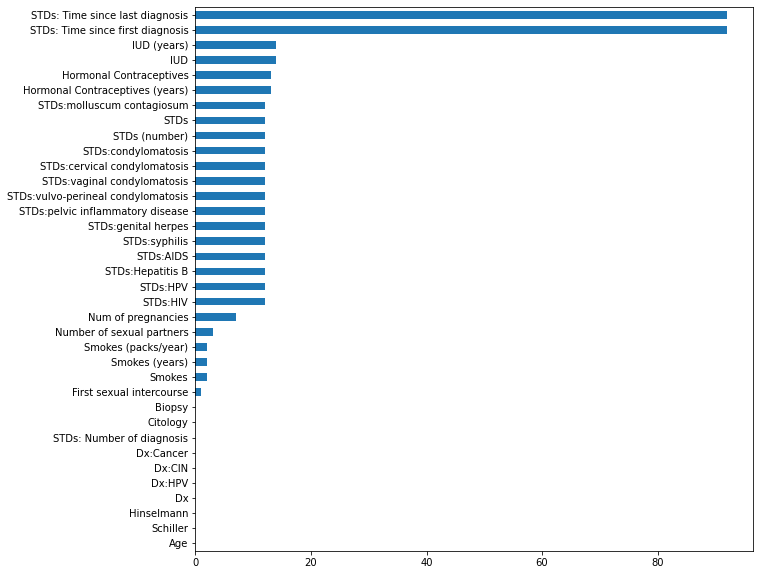

In [5]:
d= d.replace('?', np.nan)
#d.isnull().sum() 
plt.figure(figsize=(10,10))
np.round(d.isnull().sum()/d.shape[0]*100).sort_values().plot(kind='barh')

## 2. Procesamiento de Datos

Convertimos todas las columnas a tipo flotante

In [10]:
df = d
for i in df.columns:
  df[i]=df[i].astype(float)

<p align="justify">Observamos que tenemos algunas características que presentan muchos datos perdidos que no presentan una verdadera significancia, por lo tanto eliminamos éstas columnas de nuestro dataset</p>

In [11]:
df = df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)

<p align="justify">Anteriormente observamos que algunas características presentan datos perdidos representados como NAN, procedemos a llenar estos datos nulos con la media o la mediana de los datos de la columna, dependiento del tipo de dato que maneje la serie, si la serie tiene un tipo numérico se llena con la media, pero si por el contrario, la sierie es de tipo categórica (0 ó 1), la llenamos con la mediana.</p>

In [12]:
dfc = df.copy()
dfc.columns=['Age', 'No_of_sex_partner', 'First_sexual_intercourse',\
            'No_pregnancies','Smokes',  'Smokes_yrs',  'Smokes_packs_yr',  'Hormonal_Contraceptives',\
            'Hormonal_Contraceptives_years','IUD', 'IUD_years', 'STDs', 'STDs_number', 'STDs_condylomatosis',\
            'STDs_cervical_condylomatosis', 'STDs_vaginal_condylomatosis', 'STDs_vulvo_perineal_condylomatosis',\
            'STDs_syphilis', 'STDs_pelvic_inflammatory_disease', 'STDs_genital_herpes', 'STDs_molluscum_contagiosum',\
            'STDs_AIDS', 'STDs_HIV', 'STDs_Hepatitis_B', 'STDs_HPV', 'STDs_No_of_diagnosis', 'Dx_Cancer', 'Dx_CIN', 'Dx_HPV',\
            'Dx', 'Hinselmann','Schiller' ,'Citology', 'Biopsy']
dfc=dfc.drop(dfc.index[dfc.Smokes.isnull()] | dfc.index[dfc.First_sexual_intercourse.isnull()])
x_caracteristicas=list(dfc.columns)
x_caracteristicas.remove('Biopsy')
x_caracteristicas_categoricas=['Smokes','Hormonal_Contraceptives','IUD','STDs','STDs_condylomatosis','STDs_cervical_condylomatosis',
                        'STDs_vaginal_condylomatosis','STDs_vulvo_perineal_condylomatosis','STDs_syphilis','STDs_pelvic_inflammatory_disease',
                        'STDs_genital_herpes','STDs_molluscum_contagiosum','STDs_AIDS','STDs_HIV','STDs_Hepatitis_B','STDs_HPV','Dx_Cancer','Dx_CIN',
                        'Dx_HPV','Dx']
x_caracteristicas_numericas=[i for i in x_caracteristicas if i not in x_caracteristicas_categoricas]

In [13]:
#@title Llenar los datos NAN con predictores { display-mode: "form" }
#Imputación de valor perdido del DIU
df_iud = dfc.copy()
x_caracteristicas_categoricas.remove('IUD')
for i in x_caracteristicas_categoricas:
    df_iud[i]=df_iud[i].fillna(df_iud[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_iud[i]=df_iud[i].fillna(df_iud[i].median())
#df_iud=df_iud.astype('float')
df_iud[x_caracteristicas_categoricas]=df_iud[x_caracteristicas_categoricas].replace(0,'no')
df_iud[x_caracteristicas_categoricas]=df_iud[x_caracteristicas_categoricas].replace(1,'yes')
df_iud=pd.get_dummies(df_iud)
train_iud=df_iud[df_iud.IUD.isnull()==False]
test_iud=df_iud[df_iud.IUD.isnull()]
train_iud_x=train_iud.drop('IUD',axis=1)
train_iud_y=train_iud['IUD']
test_iud_x=test_iud.drop('IUD',axis=1)
test_iud_y=test_iud['IUD']
dt=DecisionTreeClassifier()
iud_model=dt.fit(train_iud_x,train_iud_y)
test_iud['IUD']=iud_model.predict(test_iud_x)
iud_complete=pd.concat([train_iud,test_iud],axis=0)
df_impute=dfc.copy()
df_impute['IUD']=iud_complete['IUD'].sort_index()

#IUD_yesars (porque si UID es 0, UID_years también será cero)
x_caracteristicas_numericas.remove('IUD_years')
df_impute['IUD_years']=df_impute['IUD_years'].fillna(0)

#Hormonal_Contraceptives
df_hor=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('Hormonal_Contraceptives')
for i in x_caracteristicas_categoricas:
    df_hor[i]=df_hor[i].fillna(df_hor[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_hor[i]=df_hor[i].fillna(df_hor[i].median())
#df_hor=df_hor.astype('float')
df_hor[x_caracteristicas_categoricas]=df_hor[x_caracteristicas_categoricas].replace(0,'no')
df_hor[x_caracteristicas_categoricas]=df_hor[x_caracteristicas_categoricas].replace(1,'yes')
df_hor=pd.get_dummies(df_hor)
train_hor=df_hor[df_hor.Hormonal_Contraceptives.isnull()==False]
test_hor=df_hor[df_hor.Hormonal_Contraceptives.isnull()]
train_hor_x=train_hor.drop('Hormonal_Contraceptives',axis=1)
train_hor_y=train_hor['Hormonal_Contraceptives']
test_hor_x=test_hor.drop('Hormonal_Contraceptives',axis=1)
test_hor_y=test_hor['Hormonal_Contraceptives']
dt=DecisionTreeClassifier()
hor_model=dt.fit(train_hor_x,train_hor_y)
test_hor['Hormonal_Contraceptives']=hor_model.predict(test_hor_x)
hor_complete=pd.concat([train_hor,test_hor],axis=0)
df_impute['Hormonal_Contraceptives']=hor_complete['Hormonal_Contraceptives'].sort_index()

#Hormonal_Contraceptives_years
df_hor_y=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('Hormonal_Contraceptives_years')
for i in x_caracteristicas_categoricas:
    df_hor_y[i]=df_hor_y[i].fillna(df_hor_y[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_hor_y[i]=df_hor_y[i].fillna(df_hor_y[i].median())
#df_hor_y=df_hor_y.astype('float')
df_hor_y[x_caracteristicas_categoricas]=df_hor_y[x_caracteristicas_categoricas].replace(0,'no')
df_hor_y[x_caracteristicas_categoricas]=df_hor_y[x_caracteristicas_categoricas].replace(1,'yes')
df_hor_y=pd.get_dummies(df_hor_y)
train_hor_yrs=df_hor_y[df_hor_y.Hormonal_Contraceptives_years.isnull()==False]
test_hor_yrs=df_hor_y[df_hor_y.Hormonal_Contraceptives_years.isnull()]
train_hor_yrs_x=train_hor_yrs.drop('Hormonal_Contraceptives_years',axis=1)
train_hor_yrs_y=train_hor_yrs['Hormonal_Contraceptives_years']
test_hor_yrs_x=test_hor_yrs.drop('Hormonal_Contraceptives_years',axis=1)
test_hor_yrs_y=test_hor_yrs['Hormonal_Contraceptives_years']
dt=DecisionTreeRegressor()
hor_yrs_model=dt.fit(train_hor_yrs_x,train_hor_yrs_y)
test_hor_yrs['Hormonal_Contraceptives_years']=hor_yrs_model.predict(test_hor_yrs_x)
hor_yrs_complete=pd.concat([train_hor_yrs,test_hor_yrs],axis=0)
df_impute['Hormonal_Contraceptives_years']=hor_yrs_complete['Hormonal_Contraceptives_years'].sort_index()

#STDs
df_std=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs')
for i in x_caracteristicas_categoricas:
    df_std[i]=df_std[i].fillna(df_std[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std[i]=df_std[i].fillna(df_std[i].median()) 
#df_std=df_std.astype('float')
df_std[x_caracteristicas_categoricas]=df_std[x_caracteristicas_categoricas].replace(0,'no')
df_std[x_caracteristicas_categoricas]=df_std[x_caracteristicas_categoricas].replace(1,'yes')
df_std=pd.get_dummies(df_std)
train_std=df_std[df_std.STDs.isnull()==False]
test_std=df_std[df_std.STDs.isnull()]
train_std_x=train_std.drop('STDs',axis=1)
train_std_y=train_std['STDs']
test_std_x=test_std.drop('STDs',axis=1)
test_std_y=test_std['STDs']
dt=DecisionTreeClassifier()
std_model=dt.fit(train_std_x,train_std_y)
test_std['STDs']=std_model.predict(test_std_x)
std_complete=pd.concat([train_std,test_std],axis=0)
df_impute['STDs']=std_complete['STDs'].sort_index()

#STDs_number
df_std_num=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('STDs_number')
for i in x_caracteristicas_categoricas:
    df_std_num[i]=df_std_num[i].fillna(df_std_num[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_num[i]=df_std_num[i].fillna(df_std_num[i].median())
#df_std_num=df_std_num.astype('float')
df_std_num[x_caracteristicas_categoricas]=df_std_num[x_caracteristicas_categoricas].replace(0,'no')
df_std_num[x_caracteristicas_categoricas]=df_std_num[x_caracteristicas_categoricas].replace(1,'yes')
df_std_num=pd.get_dummies(df_std_num)
train_std_num=df_std_num[df_std_num.STDs_number.isnull()==False]
test_std_num=df_std_num[df_std_num.STDs_number.isnull()]
train_std_num_x=train_std_num.drop('STDs_number',axis=1)
train_std_num_y=train_std_num['STDs_number']
test_std_num_x=test_std_num.drop('STDs_number',axis=1)
test_std_num_y=test_std_num['STDs_number']
dt=DecisionTreeRegressor()
std_model_num=dt.fit(train_std_num_x,train_std_num_y)
test_std_num['STDs_number']=std_model_num.predict(test_std_num_x)
std_num_complete=pd.concat([train_std_num,test_std_num],axis=0)
df_impute['STDs_number']=std_num_complete['STDs_number'].sort_index()

#STDs_condylomatosis
df_std_con=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_con[i]=df_std_con[i].fillna(df_std_con[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_con[i]=df_std_con[i].fillna(df_std_con[i].median())
#df_std_con=df_std_con.astype('float')
df_std_con[x_caracteristicas_categoricas]=df_std_con[x_caracteristicas_categoricas].replace(0,'no')
df_std_con[x_caracteristicas_categoricas]=df_std_con[x_caracteristicas_categoricas].replace(1,'yes')
df_std_con=pd.get_dummies(df_std_con)
train_std_con=df_std_con[df_std_con.STDs_condylomatosis.isnull()==False]
test_std_con=df_std_con[df_std_con.STDs_condylomatosis.isnull()]
train_std_con_x=train_std_con.drop('STDs_condylomatosis',axis=1)
train_std_con_y=train_std_con['STDs_condylomatosis']
test_std_con_x=test_std_con.drop('STDs_condylomatosis',axis=1)
test_std_con_y=test_std_con['STDs_condylomatosis']
dt=DecisionTreeClassifier()
std_model_con=dt.fit(train_std_con_x,train_std_con_y)
test_std_con['STDs_condylomatosis']=std_model_con.predict(test_std_con_x)
std_con_complete=pd.concat([train_std_con,test_std_con],axis=0)
df_impute['STDs_condylomatosis']=std_con_complete['STDs_condylomatosis'].sort_index()

#STDs_cervical_condylomatosis
df_std_cerv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_cervical_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_cerv[i]=df_std_cerv[i].fillna(df_std_cerv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_cerv[i]=df_std_cerv[i].fillna(df_std_cerv[i].median())
#df_std_cerv=df_std_cerv.astype('float')
df_std_cerv[x_caracteristicas_categoricas]=df_std_cerv[x_caracteristicas_categoricas].replace(0,'no')
df_std_cerv[x_caracteristicas_categoricas]=df_std_cerv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_cerv=pd.get_dummies(df_std_cerv)
train_std_cerv=df_std_cerv[df_std_cerv.STDs_cervical_condylomatosis.isnull()==False]
test_std_cerv=df_std_cerv[df_std_cerv.STDs_cervical_condylomatosis.isnull()]
train_std_cerv_x=train_std_cerv.drop('STDs_cervical_condylomatosis',axis=1)
train_std_cerv_y=train_std_cerv['STDs_cervical_condylomatosis']
test_std_cerv_x=test_std_cerv.drop('STDs_cervical_condylomatosis',axis=1)
test_std_cerv_y=test_std_cerv['STDs_cervical_condylomatosis']
dt=DecisionTreeClassifier()
std_model_cerv=dt.fit(train_std_cerv_x,train_std_cerv_y)
test_std_cerv['STDs_cervical_condylomatosis']=std_model_cerv.predict(test_std_cerv_x)
std_cerv_complete=pd.concat([train_std_cerv,test_std_cerv],axis=0)
df_impute['STDs_cervical_condylomatosis']=std_cerv_complete['STDs_cervical_condylomatosis'].sort_index()

#STDs_vaginal_condylomatosis
df_std_vagi=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_vaginal_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_vagi[i]=df_std_vagi[i].fillna(df_std_vagi[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_vagi[i]=df_std_vagi[i].fillna(df_std_vagi[i].median())
#df_std_vagi=df_std_vagi.astype('float')
df_std_vagi[x_caracteristicas_categoricas]=df_std_vagi[x_caracteristicas_categoricas].replace(0,'no')
df_std_vagi[x_caracteristicas_categoricas]=df_std_vagi[x_caracteristicas_categoricas].replace(1,'yes')
df_std_vagi=pd.get_dummies(df_std_vagi)
train_std_vagi=df_std_vagi[df_std_vagi.STDs_vaginal_condylomatosis.isnull()==False]
test_std_vagi=df_std_vagi[df_std_vagi.STDs_vaginal_condylomatosis.isnull()]
train_std_vagi_x=train_std_vagi.drop('STDs_vaginal_condylomatosis',axis=1)
train_std_vagi_y=train_std_vagi['STDs_vaginal_condylomatosis']
test_std_vagi_x=test_std_vagi.drop('STDs_vaginal_condylomatosis',axis=1)
test_std_vagi_y=test_std_vagi['STDs_vaginal_condylomatosis']
dt=DecisionTreeClassifier()
std_model_vagi=dt.fit(train_std_vagi_x,train_std_vagi_y)
test_std_vagi['STDs_vaginal_condylomatosis']=std_model_vagi.predict(test_std_vagi_x)
std_vagi_complete=pd.concat([train_std_vagi,test_std_vagi],axis=0)
df_impute['STDs_vaginal_condylomatosis']=std_vagi_complete['STDs_vaginal_condylomatosis'].sort_index()

#STDs_vulvo_perineal_condylomatosis
df_std_peri=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_vulvo_perineal_condylomatosis')
for i in x_caracteristicas_categoricas:
    df_std_peri[i]=df_std_peri[i].fillna(df_std_peri[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_peri[i]=df_std_peri[i].fillna(df_std_peri[i].median())
#df_std_peri=df_std_peri.astype('float')
df_std_peri[x_caracteristicas_categoricas]=df_std_peri[x_caracteristicas_categoricas].replace(0,'no')
df_std_peri[x_caracteristicas_categoricas]=df_std_peri[x_caracteristicas_categoricas].replace(1,'yes')
df_std_peri=pd.get_dummies(df_std_peri)
train_std_peri=df_std_peri[df_std_peri.STDs_vulvo_perineal_condylomatosis.isnull()==False]
test_std_peri=df_std_peri[df_std_peri.STDs_vulvo_perineal_condylomatosis.isnull()]
train_std_peri_x=train_std_peri.drop('STDs_vulvo_perineal_condylomatosis',axis=1)
train_std_peri_y=train_std_peri['STDs_vulvo_perineal_condylomatosis']
test_std_peri_x=test_std_peri.drop('STDs_vulvo_perineal_condylomatosis',axis=1)
test_std_peri_y=test_std_peri['STDs_vulvo_perineal_condylomatosis']
dt=DecisionTreeClassifier()
std_model_peri=dt.fit(train_std_peri_x,train_std_peri_y)
test_std_peri['STDs_vulvo_perineal_condylomatosis']=std_model_peri.predict(test_std_peri_x)
std_peri_complete=pd.concat([train_std_peri,test_std_peri],axis=0)
df_impute['STDs_vulvo_perineal_condylomatosis']=std_peri_complete['STDs_vulvo_perineal_condylomatosis'].sort_index()

#STDs_syphilis
df_std_syp=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_syphilis')
for i in x_caracteristicas_categoricas:
    df_std_syp[i]=df_std_syp[i].fillna(df_std_syp[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_syp[i]=df_std_syp[i].fillna(df_std_syp[i].median())
#df_std_syp=df_std_syp.astype('float')
df_std_syp[x_caracteristicas_categoricas]=df_std_syp[x_caracteristicas_categoricas].replace(0,'no')
df_std_syp[x_caracteristicas_categoricas]=df_std_syp[x_caracteristicas_categoricas].replace(1,'yes')
df_std_syp=pd.get_dummies(df_std_syp)
train_std_syp=df_std_syp[df_std_syp.STDs_syphilis.isnull()==False]
test_std_syp=df_std_syp[df_std_syp.STDs_syphilis.isnull()]
train_std_syp_x=train_std_syp.drop('STDs_syphilis',axis=1)
train_std_syp_y=train_std_syp['STDs_syphilis']
test_std_syp_x=test_std_syp.drop('STDs_syphilis',axis=1)
test_std_syp_y=test_std_syp['STDs_syphilis']
dt=DecisionTreeClassifier()
std_model_syp=dt.fit(train_std_syp_x,train_std_syp_y)
test_std_syp['STDs_syphilis']=std_model_syp.predict(test_std_syp_x)
std_syp_complete=pd.concat([train_std_syp,test_std_syp],axis=0)
df_impute['STDs_syphilis']=std_syp_complete['STDs_syphilis'].sort_index()

#STDs_pelvic_inflammatory_disease
df_std_pelv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_pelvic_inflammatory_disease')
for i in x_caracteristicas_categoricas:
    df_std_pelv[i]=df_std_pelv[i].fillna(df_std_pelv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_pelv[i]=df_std_pelv[i].fillna(df_std_pelv[i].median())                          
#df_std_pelv=df_std_pelv.astype('float')
df_std_pelv[x_caracteristicas_categoricas]=df_std_pelv[x_caracteristicas_categoricas].replace(0,'no')
df_std_pelv[x_caracteristicas_categoricas]=df_std_pelv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_pelv=pd.get_dummies(df_std_pelv)
train_std_pelv=df_std_pelv[df_std_pelv.STDs_pelvic_inflammatory_disease.isnull()==False]
test_std_pelv=df_std_pelv[df_std_pelv.STDs_pelvic_inflammatory_disease.isnull()]
train_std_pelv_x=train_std_pelv.drop('STDs_pelvic_inflammatory_disease',axis=1)
train_std_pelv_y=train_std_pelv['STDs_pelvic_inflammatory_disease']
test_std_pelv_x=test_std_pelv.drop('STDs_pelvic_inflammatory_disease',axis=1)
test_std_pelv_y=test_std_pelv['STDs_pelvic_inflammatory_disease']
dt=DecisionTreeClassifier()
std_model_pelv=dt.fit(train_std_pelv_x,train_std_pelv_y)
test_std_pelv['STDs_pelvic_inflammatory_disease']=std_model_pelv.predict(test_std_pelv_x)
std_pelv_complete=pd.concat([train_std_pelv,test_std_pelv],axis=0)
df_impute['STDs_pelvic_inflammatory_disease']=std_pelv_complete['STDs_pelvic_inflammatory_disease'].sort_index()

#STDs_genital_herpes
df_std_geni=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_genital_herpes')
for i in x_caracteristicas_categoricas:
    df_std_geni[i]=df_std_geni[i].fillna(df_std_geni[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_geni[i]=df_std_geni[i].fillna(df_std_geni[i].median())
#df_std_geni=df_std_geni.astype('float')
df_std_geni[x_caracteristicas_categoricas]=df_std_geni[x_caracteristicas_categoricas].replace(0,'no')
df_std_geni[x_caracteristicas_categoricas]=df_std_geni[x_caracteristicas_categoricas].replace(1,'yes')
df_std_geni=pd.get_dummies(df_std_geni)
train_std_geni=df_std_geni[df_std_geni.STDs_genital_herpes.isnull()==False]
test_std_geni=df_std_geni[df_std_geni.STDs_genital_herpes.isnull()]
train_std_geni_x=train_std_geni.drop('STDs_genital_herpes',axis=1)
train_std_geni_y=train_std_geni['STDs_genital_herpes']
test_std_geni_x=test_std_geni.drop('STDs_genital_herpes',axis=1)
test_std_geni_y=test_std_geni['STDs_genital_herpes']
dt=DecisionTreeClassifier()
std_model_geni=dt.fit(train_std_geni_x,train_std_geni_y)
test_std_geni['STDs_genital_herpes']=std_model_geni.predict(test_std_geni_x)
std_geni_complete=pd.concat([train_std_geni,test_std_geni],axis=0)
df_impute['STDs_genital_herpes']=std_geni_complete['STDs_genital_herpes'].sort_index()

#STDs_molluscum_contagiosum
df_std_mollu=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_molluscum_contagiosum')
for i in x_caracteristicas_categoricas:
    df_std_mollu[i]=df_std_mollu[i].fillna(df_std_mollu[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_mollu[i]=df_std_mollu[i].fillna(df_std_mollu[i].median())
#df_std_mollu=df_std_mollu.astype('float')
df_std_mollu[x_caracteristicas_categoricas]=df_std_mollu[x_caracteristicas_categoricas].replace(0,'no')
df_std_mollu[x_caracteristicas_categoricas]=df_std_mollu[x_caracteristicas_categoricas].replace(1,'yes')
df_std_mollu=pd.get_dummies(df_std_mollu)
train_std_mollu=df_std_mollu[df_std_mollu.STDs_molluscum_contagiosum.isnull()==False]
test_std_mollu=df_std_mollu[df_std_mollu.STDs_molluscum_contagiosum.isnull()]
train_std_mollu_x=train_std_mollu.drop('STDs_molluscum_contagiosum',axis=1)
train_std_mollu_y=train_std_mollu['STDs_molluscum_contagiosum']
test_std_mollu_x=test_std_mollu.drop('STDs_molluscum_contagiosum',axis=1)
test_std_mollu_y=test_std_mollu['STDs_molluscum_contagiosum']
dt=DecisionTreeClassifier()
std_model_mollu=dt.fit(train_std_mollu_x,train_std_mollu_y)
test_std_mollu['STDs_molluscum_contagiosum']=std_model_mollu.predict(test_std_mollu_x)
std_mollu_complete=pd.concat([train_std_mollu,test_std_mollu],axis=0)
df_impute['STDs_molluscum_contagiosum']=std_mollu_complete['STDs_molluscum_contagiosum'].sort_index()

#STDs_AIDS
df_std_aids=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_AIDS')
for i in x_caracteristicas_categoricas:
    df_std_aids[i]=df_std_aids[i].fillna(df_std_aids[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_aids[i]=df_std_aids[i].fillna(df_std_aids[i].median())
#df_std_aids=df_std_aids.astype('float')
df_std_aids[x_caracteristicas_categoricas]=df_std_aids[x_caracteristicas_categoricas].replace(0,'no')
df_std_aids[x_caracteristicas_categoricas]=df_std_aids[x_caracteristicas_categoricas].replace(1,'yes')
df_std_aids=pd.get_dummies(df_std_aids)
train_std_aids=df_std_aids[df_std_aids.STDs_AIDS.isnull()==False]
test_std_aids=df_std_aids[df_std_aids.STDs_AIDS.isnull()]
train_std_aids_x=train_std_aids.drop('STDs_AIDS',axis=1)
train_std_aids_y=train_std_aids['STDs_AIDS']
test_std_aids_x=test_std_aids.drop('STDs_AIDS',axis=1)
test_std_aids_y=test_std_aids['STDs_AIDS']
dt=DecisionTreeClassifier()
std_model_aids=dt.fit(train_std_aids_x,train_std_aids_y)
test_std_aids['STDs_AIDS']=std_model_aids.predict(test_std_aids_x)
std_aids_complete=pd.concat([train_std_aids,test_std_aids],axis=0)
df_impute['STDs_AIDS']=std_aids_complete['STDs_AIDS'].sort_index()

#STDs_HIV
df_std_hiv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_HIV')
for i in x_caracteristicas_categoricas:
    df_std_hiv[i]=df_std_hiv[i].fillna(df_std_hiv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_hiv[i]=df_std_hiv[i].fillna(df_std_hiv[i].median())
#df_std_hiv=df_std_hiv.astype('float')
df_std_hiv[x_caracteristicas_categoricas]=df_std_hiv[x_caracteristicas_categoricas].replace(0,'no')
df_std_hiv[x_caracteristicas_categoricas]=df_std_hiv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_hiv=pd.get_dummies(df_std_hiv)
train_std_hiv=df_std_hiv[df_std_hiv.STDs_HIV.isnull()==False]
test_std_hiv=df_std_hiv[df_std_hiv.STDs_HIV.isnull()]
train_std_hiv_x=train_std_hiv.drop('STDs_HIV',axis=1)
train_std_hiv_y=train_std_hiv['STDs_HIV']
test_std_hiv_x=test_std_hiv.drop('STDs_HIV',axis=1)
test_std_hiv_y=test_std_hiv['STDs_HIV']
dt=DecisionTreeClassifier()
std_model_hiv=dt.fit(train_std_hiv_x,train_std_hiv_y)
test_std_hiv['STDs_HIV']=std_model_hiv.predict(test_std_hiv_x)
std_hiv_complete=pd.concat([train_std_hiv,test_std_hiv],axis=0)
df_impute['STDs_HIV']=std_hiv_complete['STDs_HIV'].sort_index()

#STDs_Hepatitis_B
df_std_hepa=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_Hepatitis_B')
for i in x_caracteristicas_categoricas:
    df_std_hepa[i]=df_std_hepa[i].fillna(df_std_hepa[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_hepa[i]=df_std_hepa[i].fillna(df_std_hepa[i].median())
#df_std_hepa=df_std_hepa.astype('float')
df_std_hepa[x_caracteristicas_categoricas]=df_std_hepa[x_caracteristicas_categoricas].replace(0,'no')
df_std_hepa[x_caracteristicas_categoricas]=df_std_hepa[x_caracteristicas_categoricas].replace(1,'yes')
df_std_hepa=pd.get_dummies(df_std_hepa)
train_std_hepa=df_std_hepa[df_std_hepa.STDs_Hepatitis_B.isnull()==False]
test_std_hepa=df_std_hepa[df_std_hepa.STDs_Hepatitis_B.isnull()]
train_std_hepa_x=train_std_hepa.drop(['STDs_Hepatitis_B'],axis=1)
train_std_hepa_y=train_std_hepa['STDs_Hepatitis_B']
test_std_hepa_x=test_std_hepa.drop(['STDs_Hepatitis_B'],axis=1)
test_std_hepa_y=test_std_hepa['STDs_Hepatitis_B']
dt=DecisionTreeClassifier()
std_model_hepa=dt.fit(train_std_hepa_x,train_std_hepa_y)
test_std_hepa['STDs_Hepatitis_B']=std_model_hepa.predict(test_std_hepa_x)
std_hepa_complete=pd.concat([train_std_hepa,test_std_hepa],axis=0)
df_impute['STDs_Hepatitis_B']=std_hepa_complete['STDs_Hepatitis_B'].sort_index()

#STDs_HPV
df_std_hpv=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_categoricas.remove('STDs_HPV')
for i in x_caracteristicas_categoricas:
    df_std_hpv[i]=df_std_hpv[i].fillna(df_std_hpv[i].mode()[0])
for i in x_caracteristicas_numericas:
    df_std_hpv[i]=df_std_hpv[i].fillna(df_std_hpv[i].median())
#df_std_hpv=df_std_hpv.astype('float')
df_std_hpv[x_caracteristicas_categoricas]=df_std_hpv[x_caracteristicas_categoricas].replace(0,'no')
df_std_hpv[x_caracteristicas_categoricas]=df_std_hpv[x_caracteristicas_categoricas].replace(1,'yes')
df_std_hpv=pd.get_dummies(df_std_hpv)
train_std_hpv=df_std_hpv[df_std_hpv.STDs_HPV.isnull()==False]
test_std_hpv=df_std_hpv[df_std_hpv.STDs_HPV.isnull()]
train_std_hpv_x=train_std_hpv.drop(['STDs_HPV'],axis=1)
train_std_hpv_y=train_std_hpv['STDs_HPV']
test_std_hpv_x=test_std_hpv.drop(['STDs_HPV'],axis=1)
test_std_hpv_y=test_std_hpv['STDs_HPV']
dt=DecisionTreeClassifier()
std_model_hpv=dt.fit(train_std_hpv_x,train_std_hpv_y)
test_std_hpv['STDs_HPV']=std_model_hpv.predict(test_std_hpv_x)
std_hpv_complete=pd.concat([train_std_hpv,test_std_hpv],axis=0)
df_impute['STDs_HPV']=std_hpv_complete['STDs_HPV'].sort_index()

#No_pregnancies
df_no_preg=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('No_pregnancies')
for i in x_caracteristicas_numericas:
    df_no_preg[i]=df_no_preg[i].fillna(df_no_preg[i].median())
for i in x_caracteristicas_categoricas:
    df_no_preg[i]=df_no_preg[i].fillna(df_no_preg[i].mode()[0])
#df_no_preg=df_no_preg.astype('float')
df_no_preg[x_caracteristicas_categoricas]=df_no_preg[x_caracteristicas_categoricas].replace(0,'no')
df_no_preg[x_caracteristicas_categoricas]=df_no_preg[x_caracteristicas_categoricas].replace(1,'yes')
df_no_preg=pd.get_dummies(df_no_preg)
train_no_preg=df_no_preg[df_no_preg.No_pregnancies.isnull()==False]
test_no_preg=df_no_preg[df_no_preg.No_pregnancies.isnull()]
train_no_preg_x=train_no_preg.drop(['No_pregnancies'],axis=1)
train_no_preg_y=train_no_preg['No_pregnancies']
test_no_preg_x=test_no_preg.drop(['No_pregnancies'],axis=1)
test_no_preg_y=test_no_preg['No_pregnancies']
dt=DecisionTreeRegressor()
model_no_preg=dt.fit(train_no_preg_x,train_no_preg_y)
test_no_preg['No_pregnancies']=model_no_preg.predict(test_no_preg_x)
no_preg_complete=pd.concat([train_no_preg,test_no_preg],axis=0)
df_impute['No_pregnancies']=no_preg_complete['No_pregnancies'].sort_index()

#No_of_sex_partner
df_no_sexptnr=df_impute.drop(['Biopsy'],axis=1)
x_caracteristicas_numericas.remove('No_of_sex_partner')
for i in x_caracteristicas_numericas:
    df_no_sexptnr[i]=df_no_sexptnr[i].fillna(df_no_sexptnr[i].median())
for i in x_caracteristicas_categoricas:
    df_no_sexptnr[i]=df_no_sexptnr[i].fillna(df_no_sexptnr[i].mode()[0])
#df_no_sexptnr=df_no_sexptnr.astype('float')
df_no_sexptnr[x_caracteristicas_categoricas]=df_no_sexptnr[x_caracteristicas_categoricas].replace(0,'no')
df_no_sexptnr[x_caracteristicas_categoricas]=df_no_sexptnr[x_caracteristicas_categoricas].replace(1,'yes')
df_no_sexptnr=pd.get_dummies(df_no_sexptnr)
train_no_sexptnr=df_no_sexptnr[df_no_sexptnr.No_of_sex_partner.isnull()==False]
test_no_sexptnr=df_no_sexptnr[df_no_sexptnr.No_of_sex_partner.isnull()]
train_no_sexptnr_x=train_no_sexptnr.drop(['No_of_sex_partner'],axis=1)
train_no_sexptnr_y=train_no_sexptnr['No_of_sex_partner']
test_no_sexptnr_x=test_no_sexptnr.drop(['No_of_sex_partner'],axis=1)
test_no_sexptnr_y=test_no_sexptnr['No_of_sex_partner']
dt=DecisionTreeRegressor()
model_no_sexptnr=dt.fit(train_no_sexptnr_x,train_no_sexptnr_y)
test_no_sexptnr['No_of_sex_partner']=model_no_sexptnr.predict(test_no_sexptnr_x)
no_sexptnr_complete=pd.concat([train_no_sexptnr,test_no_sexptnr],axis=0)
df_impute['No_of_sex_partner']=no_sexptnr_complete['No_of_sex_partner'].sort_index()

In [14]:
df_impute.isnull().sum()

Age                                   0
No_of_sex_partner                     0
First_sexual_intercourse              0
No_pregnancies                        0
Smokes                                0
Smokes_yrs                            0
Smokes_packs_yr                       0
Hormonal_Contraceptives               0
Hormonal_Contraceptives_years         0
IUD                                   0
IUD_years                             0
STDs                                  0
STDs_number                           0
STDs_condylomatosis                   0
STDs_cervical_condylomatosis          0
STDs_vaginal_condylomatosis           0
STDs_vulvo_perineal_condylomatosis    0
STDs_syphilis                         0
STDs_pelvic_inflammatory_disease      0
STDs_genital_herpes                   0
STDs_molluscum_contagiosum            0
STDs_AIDS                             0
STDs_HIV                              0
STDs_Hepatitis_B                      0
STDs_HPV                              0


In [ ]:
#@title Llenar los datos NAN { display-mode: "form" }
# for continuous variable
# df['Number of sexual partners'] = df['Number of sexual partners'].fillna(df['Number of sexual partners'].median())
# df['First sexual intercourse'] = df['First sexual intercourse'].fillna(df['First sexual intercourse'].median())
# df['Num of pregnancies'] = df['Num of pregnancies'].fillna(df['Num of pregnancies'].median())

# df['Smokes'] = df['Smokes'].fillna(0)#por sugerencia
# df['Smokes (years)'] = df['Smokes (years)'].fillna(0)
# df['Smokes (packs/year)'] = df['Smokes (packs/year)'].fillna(0)

# df['Hormonal Contraceptives'] = df['Hormonal Contraceptives'].fillna(1)#por sugerencia
# df['Hormonal Contraceptives (years)'] = df['Hormonal Contraceptives (years)'].fillna(df['Hormonal Contraceptives (years)'].mean())

# df['IUD'] = df['IUD'].fillna(0) # bajo sugerencia
# df['IUD (years)'] = df['IUD (years)'].fillna(0) #bajo sugerencia

# df['STDs'] = df['STDs'].fillna(1)#v
# df['STDs (number)'] = df['STDs (number)'].fillna(df['STDs (number)'].median())
# df['STDs:condylomatosis'] = df['STDs:condylomatosis'].fillna(df['STDs:condylomatosis'].median())
# df['STDs:cervical condylomatosis'] = df['STDs:cervical condylomatosis'].fillna(df['STDs:cervical condylomatosis'].median())
# df['STDs:vaginal condylomatosis'] = df['STDs:vaginal condylomatosis'].fillna(df['STDs:vaginal condylomatosis'].median())
# df['STDs:vulvo-perineal condylomatosis'] = df['STDs:vulvo-perineal condylomatosis'].fillna(df['STDs:vulvo-perineal condylomatosis'].median())
# df['STDs:syphilis'] = df['STDs:syphilis'].fillna(df['STDs:syphilis'].median())
# df['STDs:pelvic inflammatory disease'] = df['STDs:pelvic inflammatory disease'].fillna(df['STDs:pelvic inflammatory disease'].median())
# df['STDs:genital herpes'] = df['STDs:genital herpes'].fillna(df['STDs:genital herpes'].median())
# df['STDs:molluscum contagiosum'] = df['STDs:molluscum contagiosum'].fillna(df['STDs:molluscum contagiosum'].median())
# df['STDs:AIDS'] = df['STDs:AIDS'].fillna(df['STDs:AIDS'].median())
# df['STDs:HIV'] = df['STDs:HIV'].fillna(df['STDs:HIV'].median())
# df['STDs:Hepatitis B'] = df['STDs:Hepatitis B'].fillna(df['STDs:Hepatitis B'].median())
# df['STDs:HPV'] = df['STDs:HPV'].fillna(df['STDs:HPV'].median())

Guardamos el dataset donde rellenamos todos los valores nulos

In [ ]:
df_impute.to_csv('data/df_imputation.csv')

## 3. Visualización de los datos

In [15]:
df_data = pd.read_csv('data/df_imputation.csv', index_col=0)

In [16]:
df_data[['Age','No_pregnancies', 'No_of_sex_partner','First_sexual_intercourse','Smokes_yrs','Smokes_packs_yr','STDs_No_of_diagnosis', 'Hormonal_Contraceptives_years', 'IUD_years', 'STDs_number']].describe()

,Age,No_pregnancies,No_of_sex_partner,First_sexual_intercourse,Smokes_yrs,Smokes_packs_yr,STDs_No_of_diagnosis,Hormonal_Contraceptives_years,IUD_years,STDs_number
count,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000
mean,26.812649,2.274463,2.507757,16.996420,1.216784,0.450366,0.084726,2.375990,0.445668,0.151551
std,8.529209,1.445495,1.587436,2.812965,4.090836,2.228754,0.295293,3.865077,1.823738,0.521638
min,13.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,2.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,2.000000,17.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
75%,32.000000,3.000000,3.000000,18.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
max,84.000000,11.000000,28.000000,32.000000,37.000000,37.000000,3.000000,30.000000,19.000000,4.000000


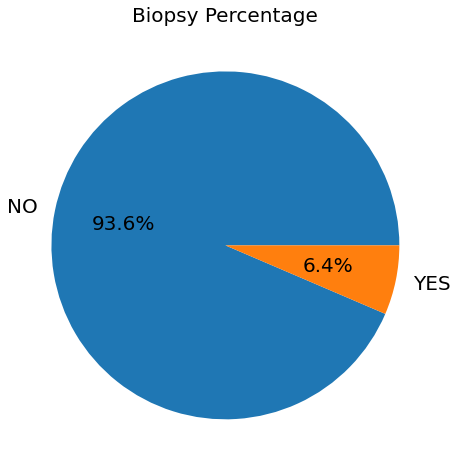

In [17]:
#@title Porcentaje de biopsia { display-mode: "form" }

impute = df_data.copy()
impute=df_data.astype('float')

plt.figure(figsize = (12,8))
plt.pie(impute['Biopsy'].value_counts(), labels = ['NO', 'YES'], autopct = '%1.1f%%', labeldistance=1.1, textprops = {'fontsize': 20})
plt.title('Biopsy Percentage', fontsize=20)
plt.show()

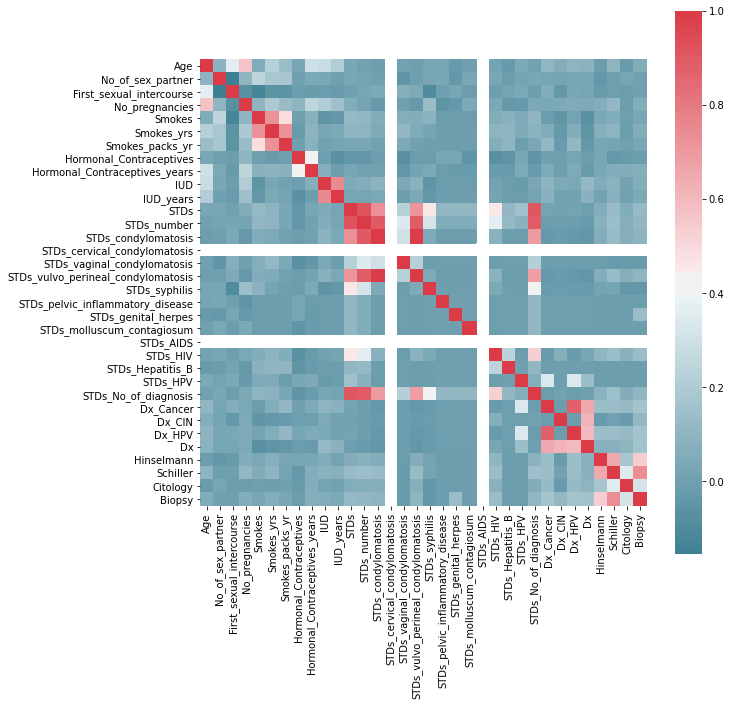

In [18]:
#@title Correlación de los datos { display-mode: "form" }
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 10))
corr = df_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

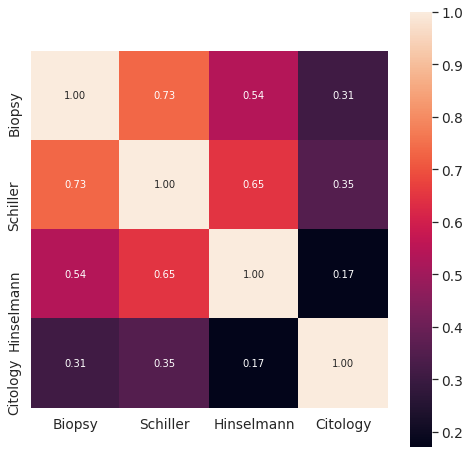

In [19]:
#@title Datos más correlacionados con Biopsia { display-mode: "form" }
k = 4 #number of variables for heatmap
cols = corr.nlargest(k, 'Biopsy')['Biopsy'].index
cm = np.corrcoef(df_data[cols].values.T)

plt.figure(figsize=(8,8)) 

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

## 4. División de las características y la clase

<p align="justify">Permutamos nuestro dataframe y porteriormente separamos las características de las clases y vemos la distribución de las etiquetas</p>  

In [20]:
#@title Funciones { display-mode: "form" }
def r_model(model,nombre,xtrain,ytrain,xtest,ytest):
  mod = {}
  modelo = model
  modelo.fit(xtrain,ytrain)
  ypred = modelo.predict(xtest)
  mod['Modelo'] = nombre
  mod['Train_Score'] = modelo.score(xtrain,ytrain)
  mod['Test_Score'] = modelo.score(xtest,ytest)
  mod['Test_accuracy'] = accuracy_score(ytest,ypred)
  mod['f1score'] = f1_score(ytest,ypred)
  reca = recall_score(ytest, ypred, average=None)
  mod['recall-0'] = reca[0]
  mod['recall-1'] = reca[1]
  prec = precision_score(ytest, ypred, average=None)
  mod['precision-0'] = prec[0]
  mod['precision-1'] = prec[1]
  #modelo.predict_proba(xtest)
  mod['roc_auc'] = roc_auc_score(ytest,ypred)
  return mod, ypred

def run_model_MC(est, xtrain, xtest, ytrain, ytest,kfold=10):
  est.fit(xtrain,ytrain)
  ypredict = est.predict(xtest)
  score=cross_val_score(est,xtest,ytest,cv=KFold(kfold,shuffle=True),scoring=make_scorer(accuracy_score))
  return est, ypredict, np.mean(score)

def matriz_confusion(ytest, ypredict):
    target= np.unique(y)
    conf_matrix = confusion_matrix(ytest, ypredict)
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, xticklabels=target, yticklabels=target, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(ytest, ypredict))
    return None

def show_train_history(train_history,train,validation):
    plt.figure(figsize=(7, 3))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

#Objetar la sobremuestra de las clases minoritarias seleccionando muestras al azar con reemplazo.
def SobremuestreoAleatorio(X,y,estrategia):
  os =  RandomOverSampler(sampling_strategy=estrategia)
  X, y = os.fit_sample(X, y)
  return X,y
  
def subsamplingOversampling(X,y,estrategia = 'auto'):
  os_us = SMOTETomek(sampling_strategy=estrategia)
  X, y = os_us.fit_sample(X, y)
  return X,y

def escalarDatos(X):
  X = StandardScaler().fit_transform(X)
  return X

def aplicarPCA(X,nCompo=7):
  pca = PCA(n_components=nCompo)
  X = pca.fit_transform(X)
  return X


In [21]:
np.random.seed(42)
df_data_shuffle = df_data.iloc[np.random.permutation(len(df_data))]
X = df_data_shuffle.drop('Biopsy', axis=1)
y = df_data_shuffle["Biopsy"]
df_scaled = pd.DataFrame(escalarDatos(X), columns = X.columns)
print ("Distribución de etiquetas de clase {}".format(Counter(y)))

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=.3, random_state = 1)

Distribución de etiquetas de clase Counter({0.0: 784, 1.0: 54})


## 5. Modelo inicial

dimension del dataset:  (838, 34) 

0.0    784
1.0     54
Name: Biopsy, dtype: int64


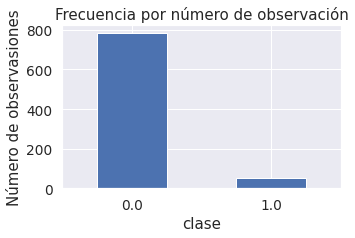

In [22]:
#@title Balance de clases { display-mode: "form" }
target = np.unique(y)
print("dimension del dataset: ",df_data.shape,"\n")
print(pd.value_counts(df_data['Biopsy'], sort = True))
plt.subplots(1,1,figsize=(5,3))
count_classes = pd.value_counts(df_data['Biopsy'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2),target)
plt.title("Frecuencia por número de observación")
plt.xlabel("clase")
plt.ylabel("Número de observasiones");

Predictor: GaussianNB
Score en test:  0.10714285714285714
Score en entrenamiento 0.10714285714285714


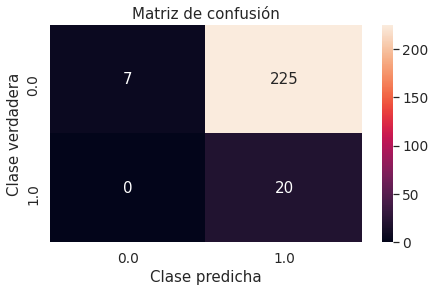

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       232
         1.0       0.08      1.00      0.15        20

    accuracy                           0.11       252
   macro avg       0.54      0.52      0.10       252
weighted avg       0.93      0.11      0.07       252




Predictor: DecisionTreeClassifier
Score en test:  0.9523809523809523
Score en entrenamiento 0.9523809523809523


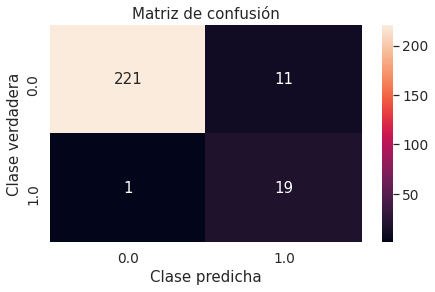

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       232
         1.0       0.63      0.95      0.76        20

    accuracy                           0.95       252
   macro avg       0.81      0.95      0.87       252
weighted avg       0.97      0.95      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9404761904761905
Score en entrenamiento 0.9404761904761905


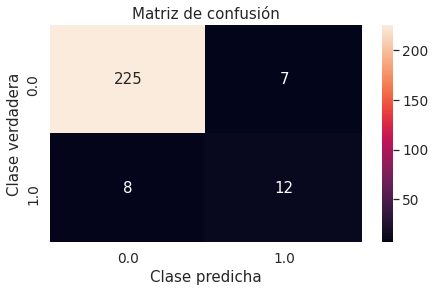

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       232
         1.0       0.63      0.60      0.62        20

    accuracy                           0.94       252
   macro avg       0.80      0.78      0.79       252
weighted avg       0.94      0.94      0.94       252




Predictor: SVC
Score en test:  0.9087301587301587
Score en entrenamiento 0.9087301587301587


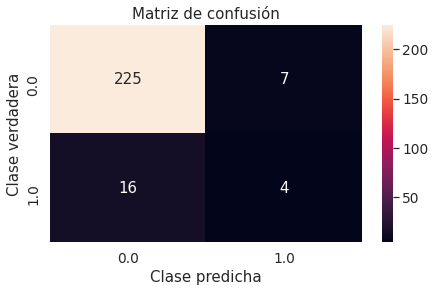

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       232
         1.0       0.36      0.20      0.26        20

    accuracy                           0.91       252
   macro avg       0.65      0.58      0.60       252
weighted avg       0.89      0.91      0.90       252






In [141]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l=[]
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Xtrain,ytrain,Xtest,ytest)
  l.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

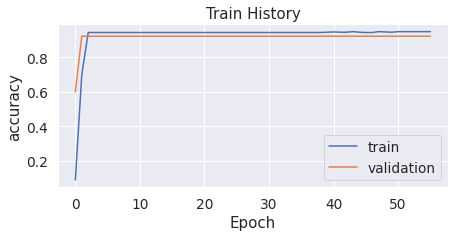

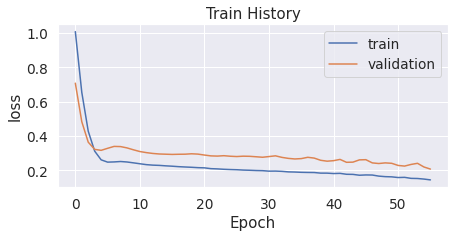

Test accuracy: 0.920634925365448
 test_loss:  0.2068408727645874


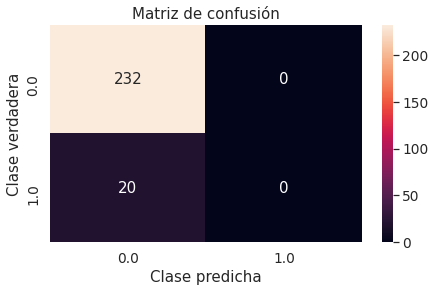

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       232
         1.0       0.00      0.00      0.00        20

    accuracy                           0.92       252
   macro avg       0.46      0.50      0.48       252
weighted avg       0.85      0.92      0.88       252



In [142]:
#@title model de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= Xtrain.values[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(Xtrain_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(Xtest_pca, y_test_ohe))
train_history = model.fit(x=Xtrain, y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(Xtest, y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(Xtest, y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(Xtest)
matriz_confusion(ytest, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(Xtrain, y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(Xtest, y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytest,predictions)
mod['f1score'] = f1_score(ytest,predictions)
reca = recall_score(ytest, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytest, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytest,predictions)
l.append(mod)

In [143]:
base_df = pd.DataFrame(l)
base_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.090444,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.984642,0.952381,0.952381,0.760000,0.952586,0.95,0.995495,0.633333,0.951293
2,RandomForestClassifier,0.991468,0.940476,0.940476,0.615385,0.969828,0.60,0.965665,0.631579,0.784914
3,SVC,0.901024,0.908730,0.908730,0.258065,0.969828,0.20,0.933610,0.363636,0.584914
4,DNN,0.948805,0.920635,0.920635,0.000000,1.000000,0.00,0.920635,0.000000,0.500000


## 6. Modelo final

### Se hace un Oversampling

In [115]:
Xtrain_s, ytrain_s = RandomOverSampler(random_state=33).fit_resample(Xtrain, ytrain.ravel())
#Xtrain_s, ytrain_s = RandomOverSampler(random_state=33).fit_resample(X, y.ravel())
print(sorted(Counter(ytrain_s).items()))

[(0.0, 552), (1.0, 552)]


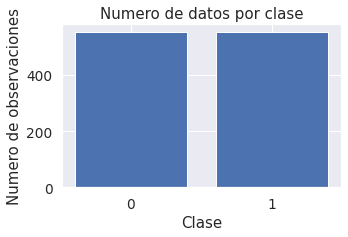

In [144]:
#@title Balance de clases  { display-mode: "form" }
plt.subplots(1,1,figsize=(5,3))
target= ['0', '1']
lista = [np.sum(ytrain_s==0),np.sum(ytrain_s==1)]
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Predictor: GaussianNB
Score en test:  0.10714285714285714
Score en entrenamiento 0.10714285714285714


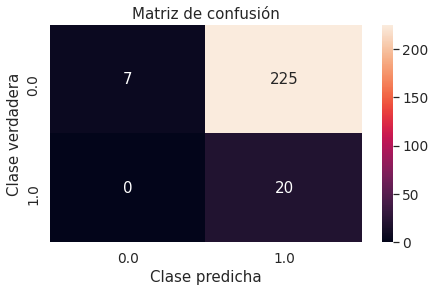

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       232
         1.0       0.08      1.00      0.15        20

    accuracy                           0.11       252
   macro avg       0.54      0.52      0.10       252
weighted avg       0.93      0.11      0.07       252




Predictor: DecisionTreeClassifier
Score en test:  0.9563492063492064
Score en entrenamiento 0.9563492063492064


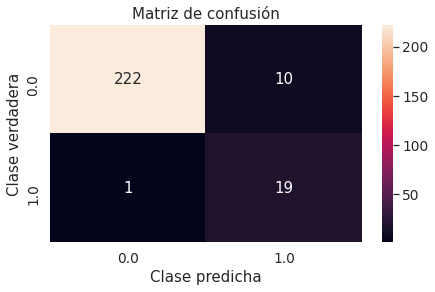

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.66      0.95      0.78        20

    accuracy                           0.96       252
   macro avg       0.83      0.95      0.88       252
weighted avg       0.97      0.96      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


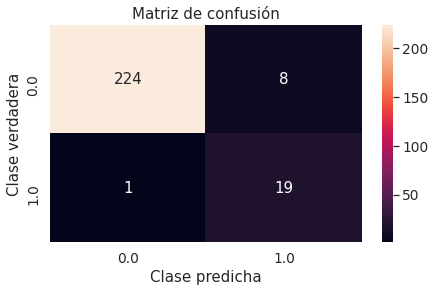

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       232
         1.0       0.70      0.95      0.81        20

    accuracy                           0.96       252
   macro avg       0.85      0.96      0.89       252
weighted avg       0.97      0.96      0.97       252




Predictor: SVC
Score en test:  0.9404761904761905
Score en entrenamiento 0.9404761904761905


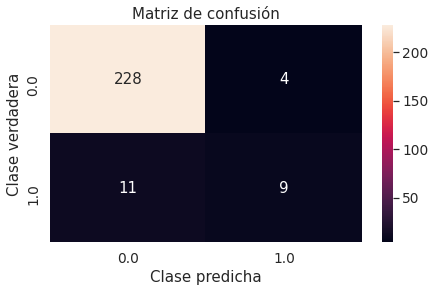

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       232
         1.0       0.69      0.45      0.55        20

    accuracy                           0.94       252
   macro avg       0.82      0.72      0.76       252
weighted avg       0.93      0.94      0.93       252






In [145]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_final=[]
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Xtrain_s,ytrain_s,Xtest,ytest)
  l_final.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

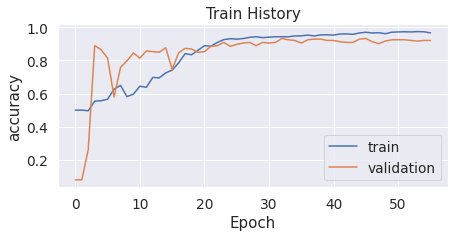

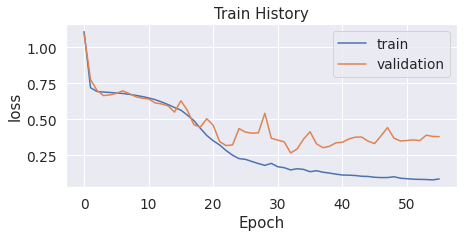

Test accuracy: 0.920634925365448
 test_loss:  0.3796827495098114


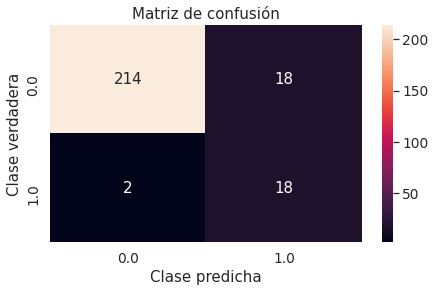

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       232
         1.0       0.50      0.90      0.64        20

    accuracy                           0.92       252
   macro avg       0.75      0.91      0.80       252
weighted avg       0.95      0.92      0.93       252



In [146]:
#@title model de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain_s, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= Xtrain_s[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(Xtrain_s_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(Xtest_pca, y_test_ohe))
train_history = model.fit(x=Xtrain_s, y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(Xtest, y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(Xtest, y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(Xtest)
matriz_confusion(ytest, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(Xtrain_s, y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(Xtest, y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytest,predictions)
mod['f1score'] = f1_score(ytest,predictions)
reca = recall_score(ytest, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytest, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytest,predictions)
l_final.append(mod)

In [147]:
oversampling_df = pd.DataFrame(l_final)
oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.517210,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.991848,0.956349,0.956349,0.775510,0.956897,0.95,0.995516,0.655172,0.953448
2,RandomForestClassifier,0.962862,0.964286,0.964286,0.808511,0.965517,0.95,0.995556,0.703704,0.957759
3,SVC,0.739130,0.940476,0.940476,0.545455,0.982759,0.45,0.953975,0.692308,0.716379
4,DNN,0.972826,0.920635,0.920635,0.642857,0.922414,0.90,0.990741,0.500000,0.911207


### Seleccionamos las mejores características para los diferentes predictores

Hemos utilizado la técnica RFE para la selección de características.
Eliminación de características recursivas (RFE), como sugiere su título, elimina características de manera recursiva, crea un modelo utilizando los atributos restantes y calcula la precisión del modelo.
RFE puede calcular la combinación de atributos que contribuyen a la predicción de la variable (o clase) objetivo.
Las características se eligen en función de la puntuación de recall, es decir, qué conjunto de características dió la puntuación de recall más alta

In [53]:
for i in range(1,df_data.shape[1]):
    model = RFE(DecisionTreeClassifier(),i).fit(X,y)
    print(X.columns[model.support_])
    x_train,x_test,y_train,y_test = train_test_split(model.transform(X),y,test_size=0.3,random_state=0)
    dt = DecisionTreeClassifier()
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    dt_recall = roc_auc_score(y_test,y_pred)
    print(dt_recall)
    print('*'*100)

Index(['Schiller'], dtype='object')
0.9794238683127572
****************************************************************************************************
Index(['Age', 'Schiller'], dtype='object')
0.6543209876543209
****************************************************************************************************
Index(['Age', 'No_of_sex_partner', 'Schiller'], dtype='object')
0.7654320987654322
****************************************************************************************************
Index(['Age', 'No_of_sex_partner', 'No_pregnancies', 'Schiller'], dtype='object')
0.9238683127572016
****************************************************************************************************
Index(['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
       'No_pregnancies', 'Schiller'],
      dtype='object')
0.9814814814814815
****************************************************************************************************
Index(['Age', 'No_of_sex_partner', 'First_sexual_int

In [72]:
rfe_dt=['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
       'No_pregnancies', 'IUD_years', 'STDs_syphilis', 'STDs_genital_herpes',
       'STDs_molluscum_contagiosum', 'STDs_AIDS', 'Dx_CIN', 'Schiller',
       'Citology']

len(rfe_dt)

12

In [56]:
for i in range(1,df_data.shape[1]):
    model = RFE(RandomForestClassifier(),i).fit(X,y)
    print(X.columns[model.support_])
    x_train,x_test,y_train,y_test = train_test_split(model.transform(X),y,test_size=0.3,random_state=0)
    dt = RandomForestClassifier()
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    dt_recall = roc_auc_score(y_test,y_pred)
    print(dt_recall)
    print('*'*100)

Index(['Schiller'], dtype='object')
0.9794238683127572
****************************************************************************************************
Index(['Age', 'Schiller'], dtype='object')
0.98559670781893
****************************************************************************************************
Index(['Age', 'Hormonal_Contraceptives_years', 'Schiller'], dtype='object')
0.8189300411522633
****************************************************************************************************
Index(['Age', 'First_sexual_intercourse', 'Hinselmann', 'Schiller'], dtype='object')
0.8189300411522633
****************************************************************************************************
Index(['Age', 'First_sexual_intercourse', 'Hormonal_Contraceptives_years',
       'Hinselmann', 'Schiller'],
      dtype='object')
0.6481481481481481
****************************************************************************************************
Index(['Age', 'First_sexual_int

In [84]:
rfe_rf=['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
       'No_pregnancies', 'Hormonal_Contraceptives_years', 'STDs_number',
       'Hinselmann', 'Schiller', 'Citology']
len(rfe_rf)

9

In [148]:
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['Biopsy'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

rfe_dt_df_train = x_train_s[rfe_dt]
rfe_dt_df_test = x_test[rfe_dt]
rfe_rf_df_train = x_train_s[rfe_rf]
rfe_rf_df_test = x_test[rfe_rf]

B = [(rfe_dt_df_train,rfe_dt_df_test),(rfe_rf_df_train,rfe_rf_df_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


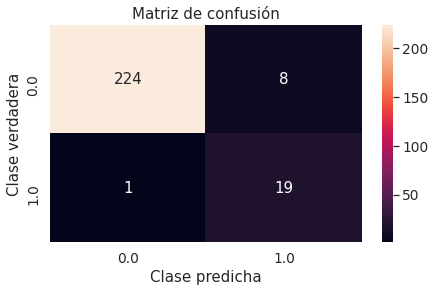

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       232
         1.0       0.70      0.95      0.81        20

    accuracy                           0.96       252
   macro avg       0.85      0.96      0.89       252
weighted avg       0.97      0.96      0.97       252




Predictor: RandomForestClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


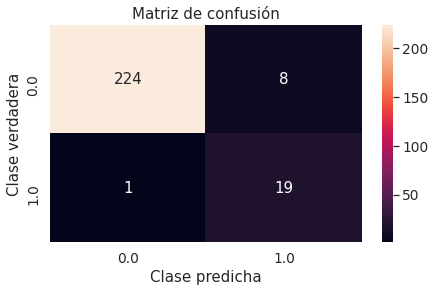

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       232
         1.0       0.70      0.95      0.81        20

    accuracy                           0.96       252
   macro avg       0.85      0.96      0.89       252
weighted avg       0.97      0.96      0.97       252






In [149]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_final_BF=[]
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],ytrain_s,B[i][1],ytest)
  l_final_BF.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

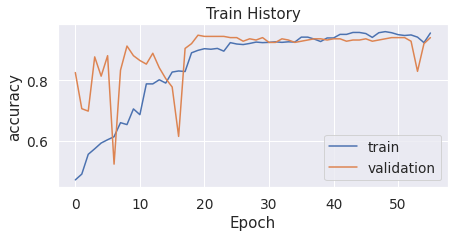

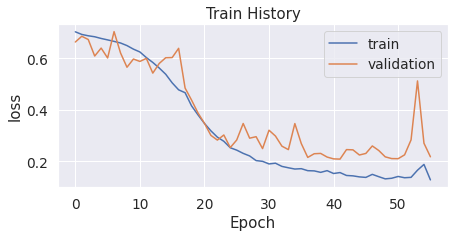

Test accuracy: 0.9404761791229248
 test_loss:  0.21745818853378296


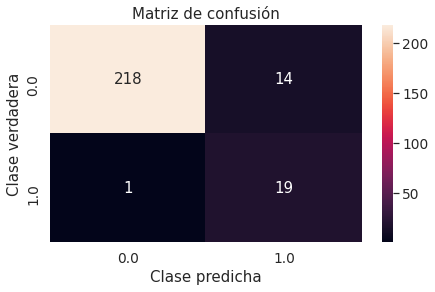

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       232
         1.0       0.58      0.95      0.72        20

    accuracy                           0.94       252
   macro avg       0.79      0.94      0.84       252
weighted avg       0.96      0.94      0.95       252



In [150]:
#@title model de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain_s, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= B[0][0].values[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(B[0][0]_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(B[0][1]_pca, y_test_ohe))
train_history = model.fit(x=B[0][0], y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(B[0][1], y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(B[0][1], y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(B[0][1])
matriz_confusion(ytest, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(B[0][0], y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(B[0][1], y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytest,predictions)
mod['f1score'] = f1_score(ytest,predictions)
reca = recall_score(ytest, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytest, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytest,predictions)
l_final_BF.append(mod)

In [151]:
BF_oversampling_df = pd.DataFrame(l_final_BF)
BF_oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.992754,0.964286,0.964286,0.808511,0.965517,0.95,0.995556,0.703704,0.957759
1,RandomForestClassifier,0.994565,0.964286,0.964286,0.808511,0.965517,0.95,0.995556,0.703704,0.957759
2,DNN,0.949275,0.940476,0.940476,0.716981,0.939655,0.95,0.995434,0.575758,0.944828


### Ajuste de hiperparámetros


Se utilizó la validación cruzada de búsqueda de cuadrícula para árboles de decisión y la validación cruzada de búsqueda aleatoria para bosque aleatorio (GridSearchCV puede tomar más tiempo) para elegir los mejores valores de parámetro

In [78]:
tree = DecisionTreeClassifier()
tree_param = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],  
    'max_depth':[3,4,5,6,7],
    'max_features':['auto','log2','sqrt'],
    'random_state':[123],
    'class_weight':['balanced',None]
}

grid = GridSearchCV(tree, tree_param, cv=10)
best_parameter_search = grid.fit(rfe_dt_df_train,y_train_s.values)
best_parameter_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'random_state': 123,
 'splitter': 'best'}

In [79]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators' : range(10,100,10),
    'max_depth' : range(2,10,1),
    'criterion' : ['gini','entropy'],
    'max_leaf_nodes' : range(2,10,1),
    'max_features' : ['auto','log2','sqrt'],
    'class_weight':['balanced',None]
}

grid = RandomizedSearchCV(rf, rf_params, cv=10)
best_parameter_search = grid.fit(rfe_rf_df_train,y_train_s.values)
best_parameter_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'log2',
 'max_leaf_nodes': 9,
 'n_estimators': 30}

Predictor: DecisionTreeClassifier
Score en test:  0.9682539682539683
Score en entrenamiento 0.9682539682539683


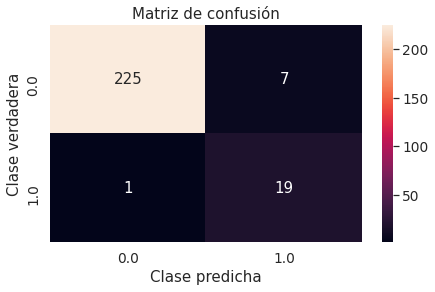

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       232
         1.0       0.73      0.95      0.83        20

    accuracy                           0.97       252
   macro avg       0.86      0.96      0.90       252
weighted avg       0.97      0.97      0.97       252




Predictor: RandomForestClassifier
Score en test:  0.9603174603174603
Score en entrenamiento 0.9603174603174603


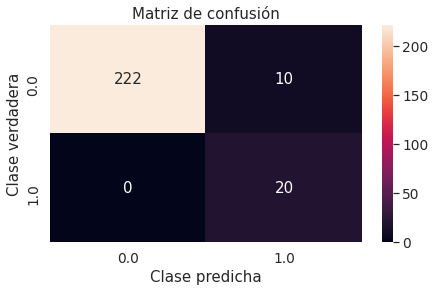

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.67      1.00      0.80        20

    accuracy                           0.96       252
   macro avg       0.83      0.98      0.89       252
weighted avg       0.97      0.96      0.96       252






In [152]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_hyper = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",max_features='auto',random_state=123,splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],ytrain_s,B[i][1],ytest)
  l_hyper.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [82]:
l_hyper.append(l_final_BF[2])

In [153]:
HBF_oversampling_df = pd.DataFrame(l_hyper)
HBF_oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.952899,0.968254,0.968254,0.826087,0.969828,0.95,0.995575,0.730769,0.959914
1,RandomForestClassifier,0.881341,0.960317,0.960317,0.800000,0.956897,1.00,1.000000,0.666667,0.978448


## 7. Diferentes predictores con la clase desbalanceada y selección de características 

Miramos las características más importantes para nuestros mejores predictores

In [85]:
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",max_features='auto',random_state=123,splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=9,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
XtrainI, XtestI, ytrainI, ytestI = train_test_split(X,y, test_size=.3, random_state = 1)

Selección secuencial hacia adelante

In [ ]:
#@title Mejores características   { display-mode: "form" }
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
sfs1 = SFS(DT,
          k_features=12,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv=KFold(10, shuffle=True),
          n_jobs=-1)
sfs2 = SFS(RF,
          k_features=9,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv=KFold(10, shuffle=True),
          n_jobs=-1)
sfs1.fit (XtrainI, ytrainI) 
sfs2.fit (XtrainI, ytrainI) 
#print('Mejor accuracy score: %.2f' % sfs.k_score_)
#print('Mejores características (indices):', sfs.k_feature_idx_)
#print('Mejores características (nombre)', sfs.k_feature_names_)

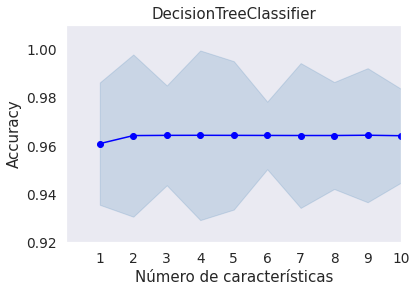

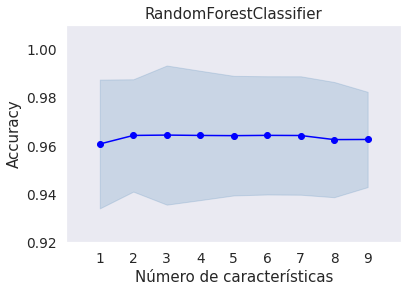

In [87]:
#@title vista gráfica   { display-mode: "form" }
#BF = pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T
BFP = [sfs1,sfs2]
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
for idx,i in enumerate(BFP):
  fig1 = plot_sfs(i.get_metric_dict(confidence_interval=0.95), kind='std_dev')
  plt.ylim([0.92, 1.01])
  plt.xlim([0, 10])
  plt.title(predictores[idx])
  plt.xlabel('Número de características')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.show()

In [129]:
Xtrain_DT,Xtest_DT = sfs1.transform(XtrainI),sfs1.transform(XtestI)
Xtrain_RF,Xtest_RF = sfs2.transform(XtrainI),sfs2.transform(XtestI)

XB = [(Xtrain_DT,Xtest_DT),(Xtrain_RF,Xtest_RF)]

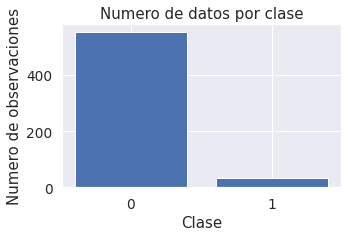

In [92]:
#@title Balance de clases  { display-mode: "form" }
plt.subplots(1,1,figsize=(5,3))
target= ['0', '1']
lista = [np.sum(ytrainI==0),np.sum(ytrainI==1)]
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Predictor: DecisionTreeClassifier
Score en test:  0.9603174603174603
Score en entrenamiento 0.9603174603174603


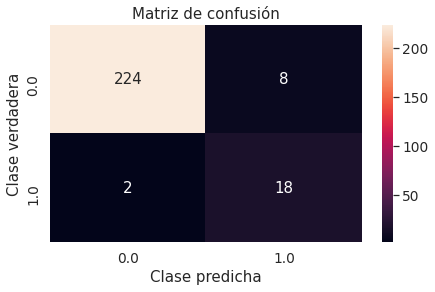

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       232
         1.0       0.69      0.90      0.78        20

    accuracy                           0.96       252
   macro avg       0.84      0.93      0.88       252
weighted avg       0.97      0.96      0.96       252




Predictor: RandomForestClassifier
Score en test:  0.9642857142857143
Score en entrenamiento 0.9642857142857143


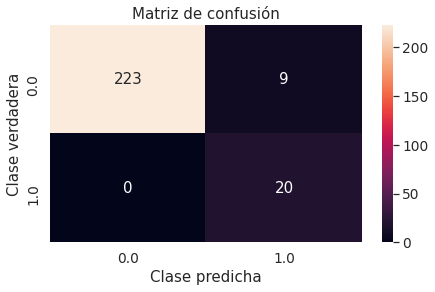

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       232
         1.0       0.69      1.00      0.82        20

    accuracy                           0.96       252
   macro avg       0.84      0.98      0.90       252
weighted avg       0.98      0.96      0.97       252






In [130]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_hyper1 = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",max_features='auto',random_state=123,splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=9,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],XB[i][0],ytrainI,XB[i][1],ytestI)
  l_hyper1.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")


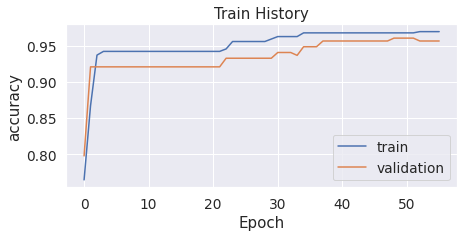

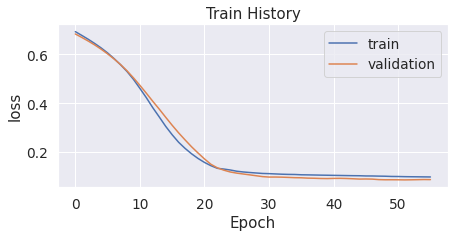

Test accuracy: 0.9563491940498352
 test_loss:  0.08606826514005661


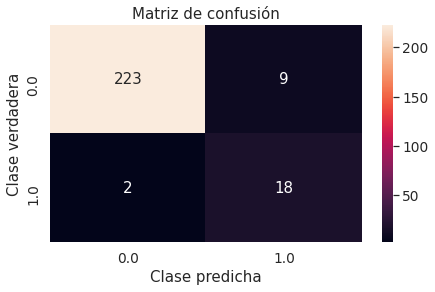

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       232
         1.0       0.67      0.90      0.77        20

    accuracy                           0.96       252
   macro avg       0.83      0.93      0.87       252
weighted avg       0.97      0.96      0.96       252



In [131]:
#@title Modelo de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrainI, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytestI, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= XB[0][0][0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(XB[0][0]_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(XB[0][1]_pca, y_test_ohe))
train_history = model.fit(x=XB[0][0], y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(XB[0][1], y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(XB[0][1], y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(XB[0][1])
matriz_confusion(ytestI, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(XB[0][0], y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(B[0][1], y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytestI,predictions)
mod['f1score'] = f1_score(ytestI,predictions)
reca = recall_score(ytestI, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytestI, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytestI,predictions)
l_hyper1.append(mod)

In [132]:
SA_base_df = pd.DataFrame(l_hyper1)
SA_base_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.967577,0.960317,0.960317,0.782609,0.965517,0.9,0.991150,0.692308,0.932759
1,RandomForestClassifier,0.967577,0.964286,0.964286,0.816327,0.961207,1.0,1.000000,0.689655,0.980603
2,DNN,0.969283,0.920635,0.956349,0.765957,0.961207,0.9,0.991111,0.666667,0.930603


## 8. Balanceando las clases

<p align="justify">Ahora con los mismos datos "X" y "y" que anteriormente se escalaron y se les aplicó un PCA con un número de componentes igual a 12, procedemos a hacer un sobremuestreo o Oversampling, en este caso creamos muestras nuevas “sintéticas” de la clase minoritaria. Usando RandomOverSampler que dió mejores resultados que otros algorítmos como SMOTE (sobremuestreo) o Smote-Tomek (hace submuestro y sobremuestro a la vez)</p>

In [133]:
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",max_features='auto',random_state=123,splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=9,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
XtrainI_s, ytrainI_s = RandomOverSampler(random_state=33).fit_resample(XtrainI, ytrainI.ravel())

In [134]:
#@title Mejores características   { display-mode: "form" }
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
sfs1 = SFS(DT,
          k_features=12,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv=KFold(10, shuffle=True),
          n_jobs=-1)
sfs2 = SFS(RF,
          k_features=9,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv=KFold(10, shuffle=True),
          n_jobs=-1)
sfs1.fit (XtrainI_s, ytrainI_s) 
sfs2.fit (XtrainI_s, ytrainI_s) 
#print('Mejor accuracy score: %.2f' % sfs.k_score_)
#print('Mejores características (indices):', sfs.k_feature_idx_)
#print('Mejores características (nombre)', sfs.k_feature_names_)

SequentialFeatureSelector(clone_estimator=True,
                          cv=KFold(n_splits=10, random_state=None, shuffle=True),
                          estimator=RandomForestClassifier(bootstrap=True,
                                                           ccp_alpha=0.0,
                                                           class_weight='balanced',
                                                           criterion='entropy',
                                                           max_depth=9,
                                                           max_features='log2',
                                                           max_leaf_nodes=7,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
  

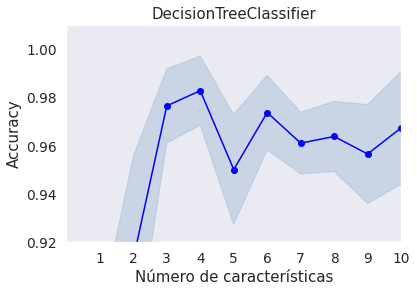

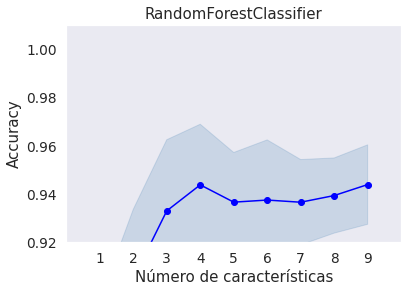

In [98]:
#@title vista gráfica   { display-mode: "form" }
#BF = pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T
BFP = [sfs1,sfs2]
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
for idx,i in enumerate(BFP):
  fig1 = plot_sfs(i.get_metric_dict(confidence_interval=0.95), kind='std_dev')
  plt.ylim([0.92, 1.01])
  plt.xlim([0, 10])
  plt.title(predictores[idx])
  plt.xlabel('Número de características')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.show()

In [135]:
Xtrain_DT,Xtest_DT = sfs1.transform(XtrainI_s),sfs1.transform(XtestI)
Xtrain_RF,Xtest_RF = sfs2.transform(XtrainI_s),sfs2.transform(XtestI)
XB = [(Xtrain_DT,Xtest_DT),(Xtrain_RF,Xtest_RF)]

In [101]:
print ("Distribución de etiquetas de clase para entrenamiento {}".format(Counter(ytrainI_s)))
print ("Distribución de etiquetas de clase para test {}".format(Counter(ytestI)))

Distribución de etiquetas de clase para entrenamiento Counter({0.0: 552, 1.0: 552})
Distribución de etiquetas de clase para test Counter({0.0: 232, 1.0: 20})


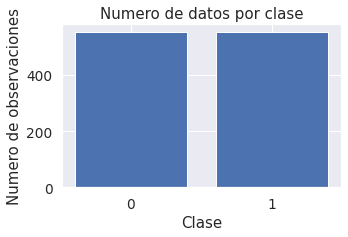

In [102]:
#@title Balance de clases con sobremuestreo { display-mode: "form" }
plt.subplots(1,1,figsize=(5,3))
target= ['0', '1']
lista = [np.sum(ytrainI_s==0),np.sum(ytrainI_s==1)]
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Predictor: DecisionTreeClassifier
Score en test:  0.9246031746031746
Score en entrenamiento 0.9246031746031746


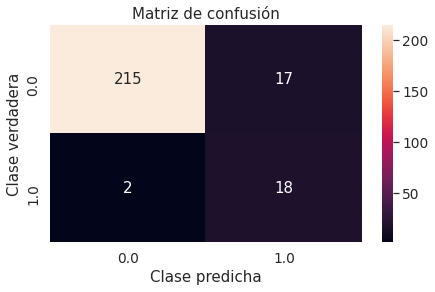

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       232
         1.0       0.51      0.90      0.65        20

    accuracy                           0.92       252
   macro avg       0.75      0.91      0.81       252
weighted avg       0.95      0.92      0.93       252




Predictor: RandomForestClassifier
Score en test:  0.9563492063492064
Score en entrenamiento 0.9563492063492064


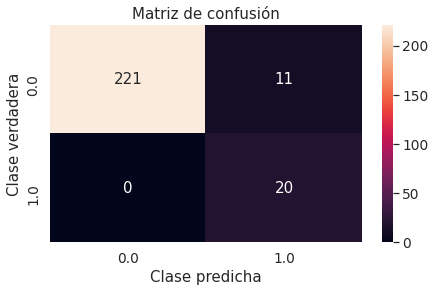

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98       232
         1.0       0.65      1.00      0.78        20

    accuracy                           0.96       252
   macro avg       0.82      0.98      0.88       252
weighted avg       0.97      0.96      0.96       252






In [136]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_hyper2 = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",max_features='auto',random_state=123,splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=9,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],XB[i][0],ytrainI_s,XB[i][1],ytestI)
  l_hyper2.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

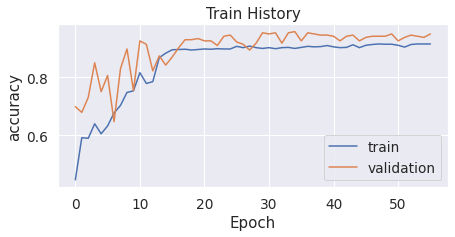

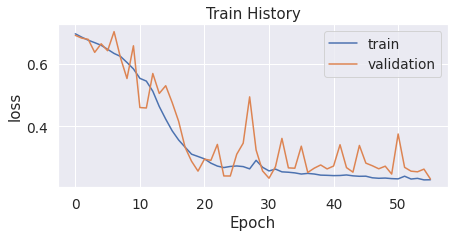

Test accuracy: 0.9484127163887024
 test_loss:  0.23283253610134125


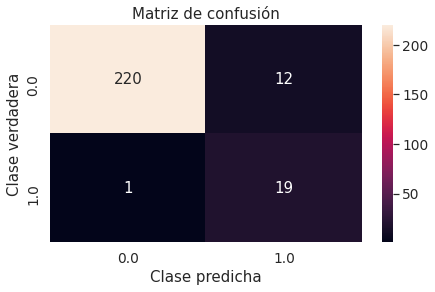

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       232
         1.0       0.61      0.95      0.75        20

    accuracy                           0.95       252
   macro avg       0.80      0.95      0.86       252
weighted avg       0.97      0.95      0.95       252



In [137]:
#@title Modelo de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrainI_s, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytestI, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= XB[0][0][0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',#binary_crossentropy
              metrics=['accuracy'])
#model.fit(XB[0][0]_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(XB[0][1]_pca, y_test_ohe))
train_history = model.fit(x=XB[0][0], y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(XB[0][1], y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(XB[0][1], y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc)
print(" test_loss: ", test_loss)
predictions = model.predict_classes(XB[0][1])
matriz_confusion(ytestI, predictions)


mod = {}
mod['Modelo'] = 'DNN'
mod['Train_Score'] = model.evaluate(XB[0][0], y_train_ohe, verbose=False)[1]
mod['Test_Score'] = model.evaluate(B[0][1], y_test_ohe, verbose=False)[1]
mod['Test_accuracy'] = accuracy_score(ytestI,predictions)
mod['f1score'] = f1_score(ytestI,predictions)
reca = recall_score(ytestI, predictions, average=None)
mod['recall-0'] = reca[0]
mod['recall-1'] = reca[1]
prec = precision_score(ytestI, predictions, average=None)
mod['precision-0'] = prec[0]
mod['precision-1'] = prec[1]
mod['roc_auc'] = roc_auc_score(ytestI,predictions)
l_hyper2.append(mod)

In [138]:
SA_oversampling_df = pd.DataFrame(l_hyper2)
SA_oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.974638,0.924603,0.924603,0.654545,0.926724,0.90,0.990783,0.514286,0.913362
1,RandomForestClassifier,0.939312,0.956349,0.956349,0.784314,0.952586,1.00,1.000000,0.645161,0.976293
2,DNN,0.905797,0.924603,0.948413,0.745098,0.948276,0.95,0.995475,0.612903,0.949138


##Análisis

In [162]:
base_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.090444,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.984642,0.952381,0.952381,0.760000,0.952586,0.95,0.995495,0.633333,0.951293
2,RandomForestClassifier,0.991468,0.940476,0.940476,0.615385,0.969828,0.60,0.965665,0.631579,0.784914
3,SVC,0.901024,0.908730,0.908730,0.258065,0.969828,0.20,0.933610,0.363636,0.584914
4,DNN,0.948805,0.920635,0.920635,0.000000,1.000000,0.00,0.920635,0.000000,0.500000


In [155]:
oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.517210,0.107143,0.107143,0.150943,0.030172,1.00,1.000000,0.081633,0.515086
1,DecisionTreeClassifier,0.991848,0.956349,0.956349,0.775510,0.956897,0.95,0.995516,0.655172,0.953448
2,RandomForestClassifier,0.962862,0.964286,0.964286,0.808511,0.965517,0.95,0.995556,0.703704,0.957759
3,SVC,0.739130,0.940476,0.940476,0.545455,0.982759,0.45,0.953975,0.692308,0.716379
4,DNN,0.972826,0.920635,0.920635,0.642857,0.922414,0.90,0.990741,0.500000,0.911207


In [156]:
BF_oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.992754,0.964286,0.964286,0.808511,0.965517,0.95,0.995556,0.703704,0.957759
1,RandomForestClassifier,0.994565,0.964286,0.964286,0.808511,0.965517,0.95,0.995556,0.703704,0.957759
2,DNN,0.949275,0.940476,0.940476,0.716981,0.939655,0.95,0.995434,0.575758,0.944828


In [157]:
HBF_oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.952899,0.968254,0.968254,0.826087,0.969828,0.95,0.995575,0.730769,0.959914
1,RandomForestClassifier,0.881341,0.960317,0.960317,0.800000,0.956897,1.00,1.000000,0.666667,0.978448


In [159]:
SA_base_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.967577,0.960317,0.960317,0.782609,0.965517,0.9,0.991150,0.692308,0.932759
1,RandomForestClassifier,0.967577,0.964286,0.964286,0.816327,0.961207,1.0,1.000000,0.689655,0.980603
2,DNN,0.969283,0.920635,0.956349,0.765957,0.961207,0.9,0.991111,0.666667,0.930603


In [160]:
SA_oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,0.974638,0.924603,0.924603,0.654545,0.926724,0.90,0.990783,0.514286,0.913362
1,RandomForestClassifier,0.939312,0.956349,0.956349,0.784314,0.952586,1.00,1.000000,0.645161,0.976293
2,DNN,0.905797,0.924603,0.948413,0.745098,0.948276,0.95,0.995475,0.612903,0.949138


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=.2)
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
KNN = KNeighborsClassifier(n_jobs=-1,weights='uniform',n_neighbors=5)
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
print('Características más importantes de GaussianNB' )
NB.fit(Xtrain,ytrain)
permumtation_impor = PermutationImportance(NB, random_state=2019).fit(Xtest_GN, ytestI)
eli5.show_weights(permumtation_impor, feature_names = Xtest_GN.columns.tolist())

In [ ]:
print('Características más importantes de DecisionTreeClassifier' )
DT.fit(Xtrain,ytrain)
permumtation_impor = PermutationImportance(DT, random_state=2019).fit(Xtest, ytest)
eli5.show_weights(permumtation_impor, feature_names = Xtest.columns.tolist())

Características más importantes de DecisionTreeClassifier


Weight,Feature
0.1035 ± 0.0315,Schiller
0.0163 ± 0.0136,First sexual intercourse
0.0081 ± 0.0119,Num of pregnancies
0.0035 ± 0.0093,Citology
0.0023 ± 0.0057,Number of sexual partners
0.0023 ± 0.0119,Age
0 ± 0.0000,Dx:Cancer
0 ± 0.0000,Hinselmann
0 ± 0.0000,Dx
0 ± 0.0000,Smokes


In [ ]:
print('Características más importantes de RandomForestClassifier' )
RF.fit(Xtrain,ytrain)
permumtation_impor = PermutationImportance(RF, random_state=2019).fit(Xtest, ytest)
eli5.show_weights(permumtation_impor, feature_names = Xtest.columns.tolist())

Características más importantes de RandomForestClassifier


Weight,Feature
0.1000 ± 0.0289,Schiller
0.0012 ± 0.0087,Hormonal Contraceptives (years)
0 ± 0.0000,STDs:Hepatitis B
0 ± 0.0000,IUD
0 ± 0.0000,IUD (years)
0 ± 0.0000,STDs (number)
0 ± 0.0000,STDs:condylomatosis
0 ± 0.0000,STDs:cervical condylomatosis
0 ± 0.0000,STDs:vaginal condylomatosis
0 ± 0.0000,Smokes


In [ ]:
print('Características más importantes de SVC' )
SV.fit(Xtrain,ytrain)
permumtation_impor = PermutationImportance(SV, random_state=2019).fit(Xtest, ytest)
eli5.show_weights(permumtation_impor, feature_names = Xtest.columns.tolist())

Características más importantes de SVC


Weight,Feature
0.0233 ± 0.0104,Schiller
0.0163 ± 0.0047,Smokes (packs/year)
0.0116 ± 0.0208,Smokes (years)
0.0081 ± 0.0057,Hormonal Contraceptives (years)
0.0058 ± 0.0000,STDs (number)
0.0058 ± 0.0000,STDs: Number of diagnosis
0.0012 ± 0.0047,First sexual intercourse
0.0012 ± 0.0047,IUD (years)
0 ± 0.0000,Dx:Cancer
0 ± 0.0000,Num of pregnancies


In [ ]:
print('Características más importantes de KNeighborsClassifier' )
KNN.fit(Xtrain,ytrain)
permumtation_impor = PermutationImportance(KNN, random_state=2019).fit(Xtest, ytest)
eli5.show_weights(permumtation_impor, feature_names = Xtest.columns.tolist())

Características más importantes de KNeighborsClassifier


Weight,Feature
0.0012 ± 0.0047,STDs
0.0012 ± 0.0047,Age
0 ± 0.0000,STDs:pelvic inflammatory disease
0 ± 0.0000,Num of pregnancies
0 ± 0.0000,Smokes
0 ± 0.0000,Smokes (years)
0 ± 0.0000,Smokes (packs/year)
0 ± 0.0000,Hormonal Contraceptives
0 ± 0.0000,Hormonal Contraceptives (years)
0 ± 0.0000,IUD


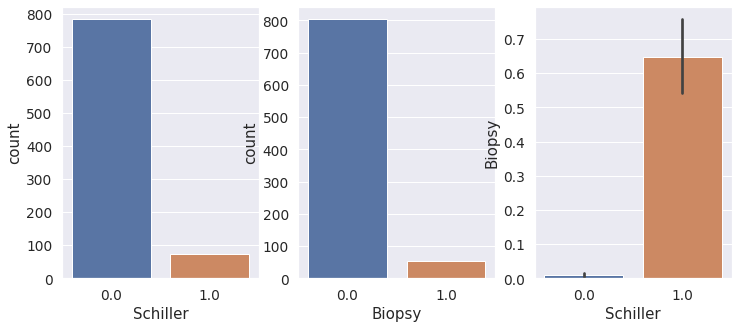

In [ ]:
#@title Schiller { display-mode: "form" }
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,5))
sns.countplot(x='Schiller', data=df_data, ax=axis1)
sns.countplot(x='Biopsy', data=df_data, ax=axis2)
sns.barplot(x='Schiller', y='Biopsy', data=df_data, ax=axis3)

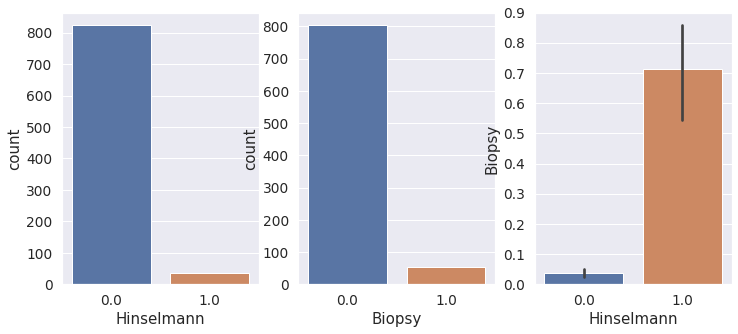

In [ ]:
#@title Hinselmann { display-mode: "form" }
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,5))
sns.countplot(x='Hinselmann', data=df_data, ax=axis1)
sns.countplot(x='Biopsy', data=df_data, ax=axis2)
sns.barplot(x='Hinselmann', y='Biopsy', data=df_data, ax=axis3)

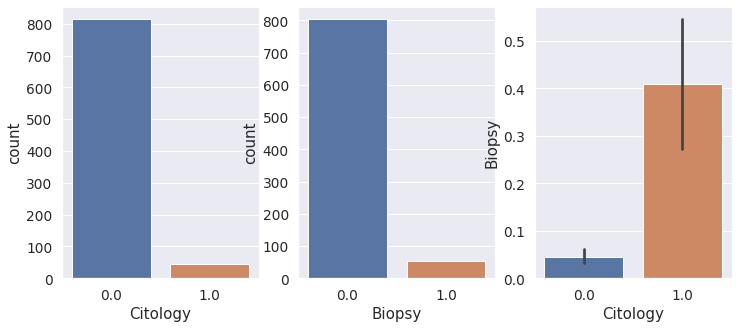

In [ ]:
#@title Citology { display-mode: "form" }
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,5))
sns.countplot(x='Citology', data=df_data, ax=axis1)
sns.countplot(x='Biopsy', data=df_data, ax=axis2)
sns.barplot(x='Citology', y='Biopsy', data=df_data, ax=axis3)

<p align="justify">Podemos observar que las características más significantes para nuestros modelos se encuentran principalmente en la prueba de Hinselmann y la de Shiller, sin embargo también hay otras características como la citología que también son relevantes, esto además lo podemos corroborar con la matriz de correlación, en donde estas tres características son la más correlacionadas con la Biopsia, esto coincide en sentido común del conocimiento médico, además pudimos observar que al balancear nuestra clase minoritaria (1) nuestros algoritmos presentan un falso negativo y falso positivo realmente bajo, aunque lo realmente importante para nosotros es que el sistema pueda clasificar de una mejor manera nuestra clase (1) que hace referencia a los falsos negativos, ya que esto representa las mujeres que realmente necesitan la biopcia y el modelo predice que no la requiere.</p>